In [ ]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 400
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=4, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


print(performance)
res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



170
50
Epoch 0 - Training loss: 1.8823912143707275
Epoch 0 - Test loss: 1.230881929397583
Epoch 1 - Training loss: 0.9700372219085693
Epoch 1 - Test loss: 0.7548732757568359
Epoch 2 - Training loss: 0.706586480140686
Epoch 2 - Test loss: 0.6309253573417664
Epoch 3 - Training loss: 0.60661780834198
Epoch 3 - Test loss: 0.5736041069030762
Epoch 4 - Training loss: 0.552209734916687
Epoch 4 - Test loss: 0.5386220812797546
Epoch 5 - Training loss: 0.5156314373016357
Epoch 5 - Test loss: 0.5147013664245605
Epoch 6 - Training loss: 0.4890553653240204
Epoch 6 - Test loss: 0.49808356165885925
Epoch 7 - Training loss: 0.4682146906852722
Epoch 7 - Test loss: 0.48661985993385315
Epoch 8 - Training loss: 0.45093411207199097
Epoch 8 - Test loss: 0.4768775701522827
Epoch 9 - Training loss: 0.43631789088249207
Epoch 9 - Test loss: 0.4693896174430847
Epoch 10 - Training loss: 0.42310166358947754
Epoch 10 - Test loss: 0.4626433551311493
Epoch 11 - Training loss: 0.4109884798526764
Epoch 11 - Test loss: 

In [ ]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 400
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=3, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



group testing: 8.87960000000021e-05
170
50
Epoch 0 - Training loss: 1.889317274093628
Epoch 0 - Test loss: 1.2592494487762451
Epoch 1 - Training loss: 0.9831910133361816
Epoch 1 - Test loss: 0.7877058386802673
Epoch 2 - Training loss: 0.7244523763656616
Epoch 2 - Test loss: 0.6397807598114014
Epoch 3 - Training loss: 0.6237288117408752
Epoch 3 - Test loss: 0.5696033239364624
Epoch 4 - Training loss: 1.0804423093795776
Epoch 4 - Test loss: 1.1584371328353882
Epoch 5 - Training loss: 0.9085196852684021
Epoch 5 - Test loss: 0.8950781226158142
Epoch 6 - Training loss: 0.8351742029190063
Epoch 6 - Test loss: 0.7959577441215515
Epoch 7 - Training loss: 0.7855632305145264
Epoch 7 - Test loss: 0.734224796295166
Epoch 8 - Training loss: 0.5768186450004578
Epoch 8 - Test loss: 0.5858246088027954
Epoch 9 - Training loss: 0.5122931003570557
Epoch 9 - Test loss: 0.4890401065349579
Epoch 10 - Training loss: 0.4826047122478485
Epoch 10 - Test loss: 0.47258177399635315
Epoch 11 - Training loss: 0.8113

group testing: 6.42880000008006e-05
170
50
Epoch 0 - Training loss: 2.108848810195923
Epoch 0 - Test loss: 1.7476706504821777
Epoch 1 - Training loss: 1.5631749629974365
Epoch 1 - Test loss: 1.3326921463012695
Epoch 2 - Training loss: 1.2460479736328125
Epoch 2 - Test loss: 1.1443626880645752
Epoch 3 - Training loss: 1.1051743030548096
Epoch 3 - Test loss: 1.0493775606155396
Epoch 4 - Training loss: 1.5142314434051514
Epoch 4 - Test loss: 1.1895167827606201
Epoch 5 - Training loss: 1.075093150138855
Epoch 5 - Test loss: 1.003800868988037
Epoch 6 - Training loss: 0.9663281440734863
Epoch 6 - Test loss: 0.9324408769607544
Epoch 7 - Training loss: 0.9094638228416443
Epoch 7 - Test loss: 0.8892285823822021
Epoch 8 - Training loss: 0.8700024485588074
Epoch 8 - Test loss: 0.8574444651603699
Epoch 9 - Training loss: 0.8384513854980469
Epoch 9 - Test loss: 0.8304348587989807
Epoch 10 - Training loss: 0.8117579221725464
Epoch 10 - Test loss: 0.8094937205314636
Epoch 11 - Training loss: 0.788433

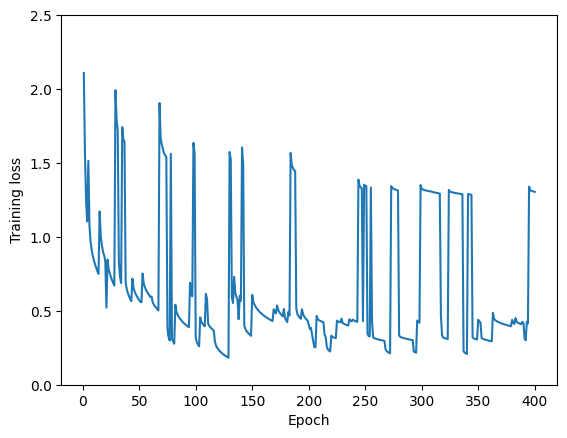

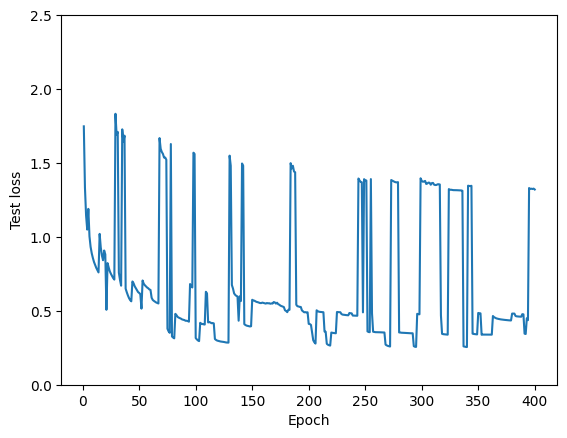

In [1]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 400
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



group testing: 0.00022019599964551162
169
50
Epoch 0 - Training loss: 2.277165412902832
Epoch 0 - Test loss: 2.2148118019104004
Epoch 1 - Training loss: 2.1526570320129395
Epoch 1 - Test loss: 2.077573537826538
Epoch 2 - Training loss: 2.054399251937866
Epoch 2 - Test loss: 1.9938745498657227
Epoch 3 - Training loss: 1.9833977222442627
Epoch 3 - Test loss: 1.958041787147522
Epoch 4 - Training loss: 1.8248077630996704
Epoch 4 - Test loss: 1.4090981483459473
Epoch 5 - Training loss: 1.2641173601150513
Epoch 5 - Test loss: 1.1275367736816406
Epoch 6 - Training loss: 1.989290714263916
Epoch 6 - Test loss: 1.9100563526153564
Epoch 7 - Training loss: 1.9181442260742188
Epoch 7 - Test loss: 1.878758192062378
Epoch 8 - Training loss: 1.8927212953567505
Epoch 8 - Test loss: 1.8616329431533813
Epoch 9 - Training loss: 1.8690028190612793
Epoch 9 - Test loss: 1.8417370319366455
Epoch 10 - Training loss: 1.852763295173645
Epoch 10 - Test loss: 1.8318322896957397
Epoch 11 - Training loss: 1.83883023

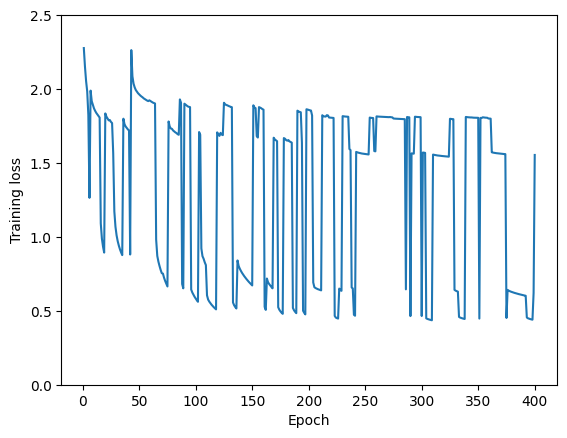

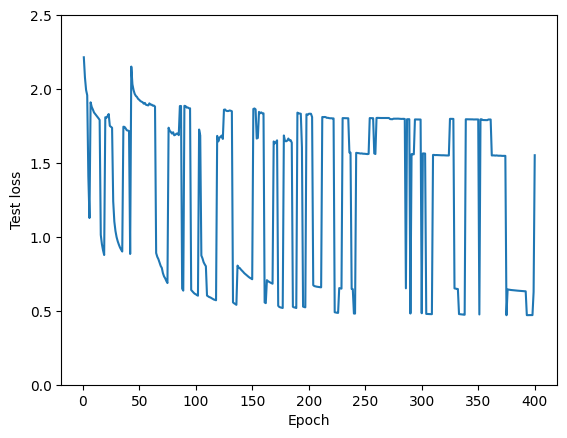

In [2]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 400
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=1, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)
print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 5000 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,2.5])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

